# Centralized learning for ECG Arrhythmia detection

In [ ]:
from pathlib import Path

import lightning as L
import matplotlib.pyplot as plt
import wandb
from dotenv import load_dotenv
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint, TQDMProgressBar
from lightning.pytorch.loggers import WandbLogger, TensorBoardLogger

from dataset_utils import Cinc2017DataModule
from model import DenseNet1dModule
import os

/home/g113056077/.pyenv/versions/ecg-fl/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Config

In [ ]:
load_dotenv()
wandb_mode = os.getenv("WANDB_MODE")

## Prepare the Dataset

In [2]:
dm = Cinc2017DataModule(batch_size=64)

## Create the Model

In [3]:
model = DenseNet1dModule(num_classes=dm.num_classes, memory_efficient=False, lr=5e-4)

## Create the Trainer

In [ ]:
checkpoint_callback = ModelCheckpoint(
    monitor="valid_loss",
    verbose=True,
    mode="min",
    save_top_k=1,
    save_last=True,
)

early_stopping_callback = EarlyStopping(
    monitor="valid_loss", patience=8, verbose=True, mode="min"
)

progress_bar_callback = TQDMProgressBar(leave=True)

if wandb_mode == 'disabled':
    logger = TensorBoardLogger(save_dir=Path('tb_logs'), name='ecg-centralized')
else:
    logger = WandbLogger(project='ecg-centralized', save_dir=Path('wandb_logs'), log_model=True)
    logger.experiment.name = "ecg-centralized"

trainer = L.Trainer(
    max_epochs=50,
    callbacks=[checkpoint_callback, early_stopping_callback, progress_bar_callback],
    logger=logger,
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: devilhyt. Use `wandb login --relogin` to force relogin


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


## Train the Model

In [5]:
trainer.fit(model, datamodule=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                      | Params | Mode  | In sizes     | Out sizes
-----------------------------------------------------------------------------------------------
0 | model         | DenseNet1d                | 1.2 M  | train | [1, 1, 3600] | [1, 3]   
1 | loss_fn       | CrossEntropyLoss          | 0      | train | ?            | ?        
2 | train_metrics | MetricCollection          | 0      | train | ?            | ?        
3 | valid_metrics | MetricCollection          | 0      | train | ?            | ?        
4 | test_metrics  | MetricCollection          | 0      | train | ?            | ?        
5 | valid_cm      | MulticlassConfusionMatrix | 0      | train | ?            | ?        
6 | test_cm       | MulticlassConfusionMatrix | 0      | train | ?            | ?        
-----------------------------------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trai

Training: |          | 0/? [00:00<?, ?it/s]                                
Epoch 0: 100%|██████████| 104/104 [00:06<00:00, 15.64it/s, v_num=purd, lr=0.0005, valid_loss=0.999, valid_acc=0.462, valid_f1=0.448, train_loss=1.070, train_acc=0.401, train_f1=0.399]

Metric valid_loss improved. New best score: 0.999
Epoch 0, global step 104: 'valid_loss' reached 0.99929 (best 0.99929), saving model to 'wandb_logs/ecg-centralized/5kw3purd/checkpoints/epoch=0-step=104.ckpt' as top 1



Valid Confusion Matrix:
tensor([[271,  25, 212],
        [ 20,  20,  36],
        [ 74,  25, 142]], device='cuda:0')
Epoch 1: 100%|██████████| 104/104 [00:06<00:00, 15.64it/s, v_num=purd, lr=0.0005, valid_loss=0.826, valid_acc=0.462, valid_f1=0.462, train_loss=1.010, train_acc=0.474, train_f1=0.468]

Metric valid_loss improved by 0.174 >= min_delta = 0.0. New best score: 0.826
Epoch 1, global step 208: 'valid_loss' reached 0.82566 (best 0.82566), saving model to 'wandb_logs/ecg-centralized/5kw3purd/checkpoints/epoch=1-step=208.ckpt' as top 1



Valid Confusion Matrix:
tensor([[465,  14,  29],
        [ 42,  19,  15],
        [163,  25,  53]], device='cuda:0')
Epoch 2: 100%|██████████| 104/104 [00:06<00:00, 15.58it/s, v_num=purd, lr=0.0005, valid_loss=0.673, valid_acc=0.619, valid_f1=0.594, train_loss=0.897, train_acc=0.567, train_f1=0.563]

Metric valid_loss improved by 0.153 >= min_delta = 0.0. New best score: 0.673



Valid Confusion Matrix:
tensor([[460,  11,  37],
        [ 10,  47,  19],
        [112,  49,  80]], device='cuda:0')


Epoch 2, global step 312: 'valid_loss' reached 0.67278 (best 0.67278), saving model to 'wandb_logs/ecg-centralized/5kw3purd/checkpoints/epoch=2-step=312.ckpt' as top 1


Epoch 3: 100%|██████████| 104/104 [00:06<00:00, 15.70it/s, v_num=purd, lr=0.0005, valid_loss=0.571, valid_acc=0.704, valid_f1=0.676, train_loss=0.705, train_acc=0.682, train_f1=0.670]

Metric valid_loss improved by 0.102 >= min_delta = 0.0. New best score: 0.571
Epoch 3, global step 416: 'valid_loss' reached 0.57101 (best 0.57101), saving model to 'wandb_logs/ecg-centralized/5kw3purd/checkpoints/epoch=3-step=416.ckpt' as top 1



Valid Confusion Matrix:
tensor([[457,  10,  41],
        [  6,  58,  12],
        [ 93,  40, 108]], device='cuda:0')
Epoch 4: 100%|██████████| 104/104 [00:06<00:00, 15.02it/s, v_num=purd, lr=0.0005, valid_loss=0.529, valid_acc=0.740, valid_f1=0.724, train_loss=0.619, train_acc=0.725, train_f1=0.719]
Valid Confusion Matrix:
tensor([[473,   5,  30],
        [  9,  60,   7],
        [ 89,  32, 120]], device='cuda:0')


Metric valid_loss improved by 0.042 >= min_delta = 0.0. New best score: 0.529
Epoch 4, global step 520: 'valid_loss' reached 0.52950 (best 0.52950), saving model to 'wandb_logs/ecg-centralized/5kw3purd/checkpoints/epoch=4-step=520.ckpt' as top 1


Epoch 5: 100%|██████████| 104/104 [00:06<00:00, 15.63it/s, v_num=purd, lr=0.0005, valid_loss=0.508, valid_acc=0.774, valid_f1=0.756, train_loss=0.560, train_acc=0.765, train_f1=0.761]

Metric valid_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.508



Valid Confusion Matrix:
tensor([[465,   6,  37],
        [  4,  63,   9],
        [ 75,  27, 139]], device='cuda:0')


Epoch 5, global step 624: 'valid_loss' reached 0.50843 (best 0.50843), saving model to 'wandb_logs/ecg-centralized/5kw3purd/checkpoints/epoch=5-step=624.ckpt' as top 1


Epoch 6: 100%|██████████| 104/104 [00:06<00:00, 15.11it/s, v_num=purd, lr=0.0005, valid_loss=0.479, valid_acc=0.779, valid_f1=0.775, train_loss=0.510, train_acc=0.790, train_f1=0.787]

Metric valid_loss improved by 0.029 >= min_delta = 0.0. New best score: 0.479
Epoch 6, global step 728: 'valid_loss' reached 0.47935 (best 0.47935), saving model to 'wandb_logs/ecg-centralized/5kw3purd/checkpoints/epoch=6-step=728.ckpt' as top 1



Valid Confusion Matrix:
tensor([[477,   4,  27],
        [  5,  60,  11],
        [ 71,  23, 147]], device='cuda:0')
Epoch 7: 100%|██████████| 104/104 [00:06<00:00, 15.57it/s, v_num=purd, lr=0.0005, valid_loss=0.501, valid_acc=0.759, valid_f1=0.742, train_loss=0.493, train_acc=0.796, train_f1=0.793]

Epoch 7, global step 832: 'valid_loss' was not in top 1



Valid Confusion Matrix:
tensor([[479,   4,  25],
        [  8,  62,   6],
        [ 83,  33, 125]], device='cuda:0')
Epoch 8: 100%|██████████| 104/104 [00:06<00:00, 15.65it/s, v_num=purd, lr=0.0005, valid_loss=0.475, valid_acc=0.775, valid_f1=0.756, train_loss=0.496, train_acc=0.793, train_f1=0.790]

Metric valid_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.475
Epoch 8, global step 936: 'valid_loss' reached 0.47505 (best 0.47505), saving model to 'wandb_logs/ecg-centralized/5kw3purd/checkpoints/epoch=8-step=936.ckpt' as top 1



Valid Confusion Matrix:
tensor([[473,   9,  26],
        [  7,  63,   6],
        [ 77,  28, 136]], device='cuda:0')
Epoch 9: 100%|██████████| 104/104 [00:06<00:00, 15.26it/s, v_num=purd, lr=0.0005, valid_loss=0.493, valid_acc=0.780, valid_f1=0.763, train_loss=0.479, train_acc=0.801, train_f1=0.798]

Epoch 9, global step 1040: 'valid_loss' was not in top 1



Valid Confusion Matrix:
tensor([[463,   5,  40],
        [  3,  61,  12],
        [ 61,  29, 151]], device='cuda:0')
Epoch 10: 100%|██████████| 104/104 [00:06<00:00, 15.54it/s, v_num=purd, lr=0.0005, valid_loss=0.468, valid_acc=0.784, valid_f1=0.757, train_loss=0.453, train_acc=0.813, train_f1=0.810]

Metric valid_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.468
Epoch 10, global step 1144: 'valid_loss' reached 0.46833 (best 0.46833), saving model to 'wandb_logs/ecg-centralized/5kw3purd/checkpoints/epoch=10-step=1144.ckpt' as top 1



Valid Confusion Matrix:
tensor([[466,   8,  34],
        [  5,  64,   7],
        [ 64,  34, 143]], device='cuda:0')
Epoch 11: 100%|██████████| 104/104 [00:06<00:00, 15.30it/s, v_num=purd, lr=0.0005, valid_loss=0.434, valid_acc=0.797, valid_f1=0.801, train_loss=0.467, train_acc=0.805, train_f1=0.803]

Metric valid_loss improved by 0.034 >= min_delta = 0.0. New best score: 0.434
Epoch 11, global step 1248: 'valid_loss' reached 0.43385 (best 0.43385), saving model to 'wandb_logs/ecg-centralized/5kw3purd/checkpoints/epoch=11-step=1248.ckpt' as top 1



Valid Confusion Matrix:
tensor([[465,   4,  39],
        [  3,  58,  15],
        [ 55,  14, 172]], device='cuda:0')
Epoch 12: 100%|██████████| 104/104 [00:06<00:00, 15.39it/s, v_num=purd, lr=0.0005, valid_loss=0.433, valid_acc=0.801, valid_f1=0.797, train_loss=0.453, train_acc=0.815, train_f1=0.814]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.433
Epoch 12, global step 1352: 'valid_loss' reached 0.43347 (best 0.43347), saving model to 'wandb_logs/ecg-centralized/5kw3purd/checkpoints/epoch=12-step=1352.ckpt' as top 1



Valid Confusion Matrix:
tensor([[471,   6,  31],
        [  5,  64,   7],
        [ 72,  16, 153]], device='cuda:0')
Epoch 13: 100%|██████████| 104/104 [00:06<00:00, 15.17it/s, v_num=purd, lr=0.0005, valid_loss=0.433, valid_acc=0.810, valid_f1=0.811, train_loss=0.431, train_acc=0.830, train_f1=0.828]

Metric valid_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.433
Epoch 13, global step 1456: 'valid_loss' reached 0.43320 (best 0.43320), saving model to 'wandb_logs/ecg-centralized/5kw3purd/checkpoints/epoch=13-step=1456.ckpt' as top 1



Valid Confusion Matrix:
tensor([[468,   4,  36],
        [  2,  60,  14],
        [ 54,  14, 173]], device='cuda:0')
Epoch 14: 100%|██████████| 104/104 [00:07<00:00, 14.83it/s, v_num=purd, lr=0.0005, valid_loss=0.429, valid_acc=0.808, valid_f1=0.807, train_loss=0.438, train_acc=0.817, train_f1=0.815]

Metric valid_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.429
Epoch 14, global step 1560: 'valid_loss' reached 0.42861 (best 0.42861), saving model to 'wandb_logs/ecg-centralized/5kw3purd/checkpoints/epoch=14-step=1560.ckpt' as top 1



Valid Confusion Matrix:
tensor([[462,   3,  43],
        [  4,  60,  12],
        [ 50,  16, 175]], device='cuda:0')
Epoch 15: 100%|██████████| 104/104 [00:06<00:00, 15.64it/s, v_num=purd, lr=0.0005, valid_loss=0.423, valid_acc=0.808, valid_f1=0.810, train_loss=0.421, train_acc=0.828, train_f1=0.826]
Valid Confusion Matrix:
tensor([[473,   3,  32],
        [  4,  61,  11],
        [ 60,  15, 166]], device='cuda:0')


Metric valid_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.423
Epoch 15, global step 1664: 'valid_loss' reached 0.42344 (best 0.42344), saving model to 'wandb_logs/ecg-centralized/5kw3purd/checkpoints/epoch=15-step=1664.ckpt' as top 1


Epoch 16: 100%|██████████| 104/104 [00:06<00:00, 15.84it/s, v_num=purd, lr=0.0005, valid_loss=0.415, valid_acc=0.779, valid_f1=0.784, train_loss=0.404, train_acc=0.841, train_f1=0.839]

Metric valid_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.415
Epoch 16, global step 1768: 'valid_loss' reached 0.41505 (best 0.41505), saving model to 'wandb_logs/ecg-centralized/5kw3purd/checkpoints/epoch=16-step=1768.ckpt' as top 1



Valid Confusion Matrix:
tensor([[471,   4,  33],
        [  6,  56,  14],
        [ 62,  17, 162]], device='cuda:0')
Epoch 17: 100%|██████████| 104/104 [00:06<00:00, 15.77it/s, v_num=purd, lr=0.0005, valid_loss=0.458, valid_acc=0.826, valid_f1=0.801, train_loss=0.423, train_acc=0.832, train_f1=0.830]

Epoch 17, global step 1872: 'valid_loss' was not in top 1



Valid Confusion Matrix:
tensor([[466,   6,  36],
        [  2,  67,   7],
        [ 50,  27, 164]], device='cuda:0')
Epoch 18: 100%|██████████| 104/104 [00:06<00:00, 15.74it/s, v_num=purd, lr=0.0005, valid_loss=0.406, valid_acc=0.812, valid_f1=0.814, train_loss=0.387, train_acc=0.847, train_f1=0.846]

Metric valid_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.406
Epoch 18, global step 1976: 'valid_loss' reached 0.40612 (best 0.40612), saving model to 'wandb_logs/ecg-centralized/5kw3purd/checkpoints/epoch=18-step=1976.ckpt' as top 1



Valid Confusion Matrix:
tensor([[475,   4,  29],
        [  7,  61,   8],
        [ 58,  15, 168]], device='cuda:0')
Epoch 19: 100%|██████████| 104/104 [00:06<00:00, 15.54it/s, v_num=purd, lr=0.0005, valid_loss=0.459, valid_acc=0.813, valid_f1=0.793, train_loss=0.390, train_acc=0.843, train_f1=0.841]

Epoch 19, global step 2080: 'valid_loss' was not in top 1



Valid Confusion Matrix:
tensor([[453,   4,  51],
        [  2,  64,  10],
        [ 47,  24, 170]], device='cuda:0')
Epoch 20: 100%|██████████| 104/104 [00:06<00:00, 15.68it/s, v_num=purd, lr=0.0005, valid_loss=0.407, valid_acc=0.818, valid_f1=0.816, train_loss=0.378, train_acc=0.850, train_f1=0.848]

Epoch 20, global step 2184: 'valid_loss' was not in top 1



Valid Confusion Matrix:
tensor([[460,   7,  41],
        [  0,  60,  16],
        [ 47,  11, 183]], device='cuda:0')
Epoch 21: 100%|██████████| 104/104 [00:06<00:00, 15.75it/s, v_num=purd, lr=0.0005, valid_loss=0.415, valid_acc=0.838, valid_f1=0.824, train_loss=0.367, train_acc=0.855, train_f1=0.853]

Epoch 21, global step 2288: 'valid_loss' was not in top 1



Valid Confusion Matrix:
tensor([[464,   3,  41],
        [  0,  67,   9],
        [ 50,  18, 173]], device='cuda:0')
Epoch 22: 100%|██████████| 104/104 [00:06<00:00, 15.40it/s, v_num=purd, lr=0.0005, valid_loss=0.395, valid_acc=0.829, valid_f1=0.815, train_loss=0.367, train_acc=0.854, train_f1=0.853]

Metric valid_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.395
Epoch 22, global step 2392: 'valid_loss' reached 0.39541 (best 0.39541), saving model to 'wandb_logs/ecg-centralized/5kw3purd/checkpoints/epoch=22-step=2392.ckpt' as top 1



Valid Confusion Matrix:
tensor([[478,   4,  26],
        [  3,  68,   5],
        [ 63,  21, 157]], device='cuda:0')
Epoch 23: 100%|██████████| 104/104 [00:06<00:00, 14.94it/s, v_num=purd, lr=0.0005, valid_loss=0.403, valid_acc=0.832, valid_f1=0.819, train_loss=0.376, train_acc=0.853, train_f1=0.851]

Epoch 23, global step 2496: 'valid_loss' was not in top 1



Valid Confusion Matrix:
tensor([[472,   5,  31],
        [  3,  66,   7],
        [ 54,  19, 168]], device='cuda:0')
Epoch 24: 100%|██████████| 104/104 [00:06<00:00, 15.67it/s, v_num=purd, lr=0.0005, valid_loss=0.426, valid_acc=0.828, valid_f1=0.814, train_loss=0.354, train_acc=0.858, train_f1=0.856]

Epoch 24, global step 2600: 'valid_loss' was not in top 1



Valid Confusion Matrix:
tensor([[460,   5,  43],
        [  2,  65,   9],
        [ 49,  18, 174]], device='cuda:0')
Epoch 25: 100%|██████████| 104/104 [00:07<00:00, 14.85it/s, v_num=purd, lr=0.0005, valid_loss=0.415, valid_acc=0.823, valid_f1=0.826, train_loss=0.360, train_acc=0.857, train_f1=0.855]

Epoch 25, global step 2704: 'valid_loss' was not in top 1



Valid Confusion Matrix:
tensor([[452,   2,  54],
        [  2,  62,  12],
        [ 48,   9, 184]], device='cuda:0')
Epoch 26: 100%|██████████| 104/104 [00:06<00:00, 15.50it/s, v_num=purd, lr=0.0005, valid_loss=0.427, valid_acc=0.795, valid_f1=0.811, train_loss=0.367, train_acc=0.859, train_f1=0.858]
Valid Confusion Matrix:
tensor([[465,   3,  40],
        [  2,  54,  20],
        [ 51,   7, 183]], device='cuda:0')


Epoch 26, global step 2808: 'valid_loss' was not in top 1


Epoch 27: 100%|██████████| 104/104 [00:06<00:00, 15.65it/s, v_num=purd, lr=0.00025, valid_loss=0.377, valid_acc=0.827, valid_f1=0.825, train_loss=0.321, train_acc=0.877, train_f1=0.876]
Valid Confusion Matrix:
tensor([[474,   4,  30],
        [  4,  64,   8],
        [ 57,  14, 170]], device='cuda:0')


Metric valid_loss improved by 0.018 >= min_delta = 0.0. New best score: 0.377
Epoch 27, global step 2912: 'valid_loss' reached 0.37744 (best 0.37744), saving model to 'wandb_logs/ecg-centralized/5kw3purd/checkpoints/epoch=27-step=2912.ckpt' as top 1


Epoch 28: 100%|██████████| 104/104 [00:06<00:00, 15.62it/s, v_num=purd, lr=0.00025, valid_loss=0.392, valid_acc=0.828, valid_f1=0.826, train_loss=0.328, train_acc=0.873, train_f1=0.871]

Epoch 28, global step 3016: 'valid_loss' was not in top 1



Valid Confusion Matrix:
tensor([[474,   5,  29],
        [  5,  64,   7],
        [ 56,  14, 171]], device='cuda:0')
Epoch 29: 100%|██████████| 104/104 [00:06<00:00, 15.76it/s, v_num=purd, lr=0.00025, valid_loss=0.384, valid_acc=0.819, valid_f1=0.824, train_loss=0.309, train_acc=0.877, train_f1=0.876]

Epoch 29, global step 3120: 'valid_loss' was not in top 1



Valid Confusion Matrix:
tensor([[469,   4,  35],
        [  3,  61,  12],
        [ 55,  10, 176]], device='cuda:0')
Epoch 30: 100%|██████████| 104/104 [00:06<00:00, 15.25it/s, v_num=purd, lr=0.00025, valid_loss=0.398, valid_acc=0.825, valid_f1=0.824, train_loss=0.309, train_acc=0.880, train_f1=0.879]

Epoch 30, global step 3224: 'valid_loss' was not in top 1



Valid Confusion Matrix:
tensor([[465,   4,  39],
        [  4,  64,   8],
        [ 56,  12, 173]], device='cuda:0')
Epoch 31: 100%|██████████| 104/104 [00:06<00:00, 15.34it/s, v_num=purd, lr=0.00025, valid_loss=0.430, valid_acc=0.826, valid_f1=0.821, train_loss=0.312, train_acc=0.878, train_f1=0.878]

Epoch 31, global step 3328: 'valid_loss' was not in top 1



Valid Confusion Matrix:
tensor([[466,   3,  39],
        [  1,  64,  11],
        [ 53,  15, 173]], device='cuda:0')
Epoch 32: 100%|██████████| 104/104 [00:06<00:00, 15.51it/s, v_num=purd, lr=0.000125, valid_loss=0.406, valid_acc=0.818, valid_f1=0.815, train_loss=0.301, train_acc=0.885, train_f1=0.884]

Epoch 32, global step 3432: 'valid_loss' was not in top 1



Valid Confusion Matrix:
tensor([[467,   5,  36],
        [  3,  62,  11],
        [ 54,  14, 173]], device='cuda:0')
Epoch 33: 100%|██████████| 104/104 [00:06<00:00, 15.31it/s, v_num=purd, lr=0.000125, valid_loss=0.401, valid_acc=0.826, valid_f1=0.827, train_loss=0.289, train_acc=0.888, train_f1=0.887]

Epoch 33, global step 3536: 'valid_loss' was not in top 1



Valid Confusion Matrix:
tensor([[465,   3,  40],
        [  1,  64,  11],
        [ 56,  11, 174]], device='cuda:0')
Epoch 34: 100%|██████████| 104/104 [00:06<00:00, 15.08it/s, v_num=purd, lr=0.000125, valid_loss=0.398, valid_acc=0.820, valid_f1=0.824, train_loss=0.291, train_acc=0.883, train_f1=0.882]

Epoch 34, global step 3640: 'valid_loss' was not in top 1



Valid Confusion Matrix:
tensor([[469,   5,  34],
        [  3,  61,  12],
        [ 54,  10, 177]], device='cuda:0')
Epoch 35: 100%|██████████| 104/104 [00:06<00:00, 15.42it/s, v_num=purd, lr=0.000125, valid_loss=0.412, valid_acc=0.839, valid_f1=0.830, train_loss=0.281, train_acc=0.887, train_f1=0.886]

Monitored metric valid_loss did not improve in the last 8 records. Best score: 0.377. Signaling Trainer to stop.
Epoch 35, global step 3744: 'valid_loss' was not in top 1



Valid Confusion Matrix:
tensor([[462,   4,  42],
        [  2,  66,   8],
        [ 49,  14, 178]], device='cuda:0')


## Evaluate the Model on the Test Set

In [6]:
model = DenseNet1dModule.load_from_checkpoint(checkpoint_callback.best_model_path)

_ = trainer.test(model, dataloaders=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 13/13 [00:00<00:00, 49.44it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8171041011810303     │
│          test_f1          │    0.8207087516784668     │
│         test_loss         │    0.4554614722728729     │
└───────────────────────────┴───────────────────────────┘

## Confusion Matrix

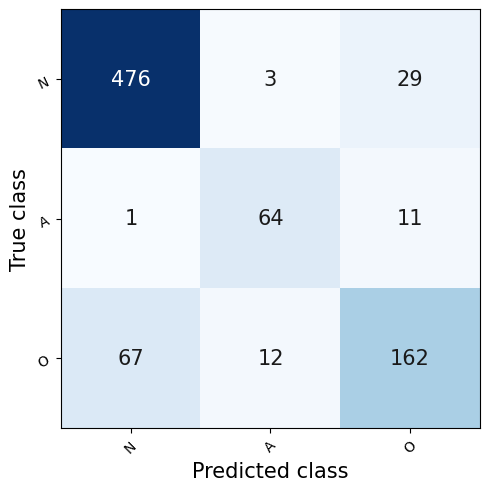

In [7]:
fig, ax = model.test_cm.plot(
    model.test_cm_log, cmap="Blues", labels=dm.test_set.classes
)
plt.show()
wandb.log({"test_cm": fig})

In [8]:
wandb.finish()

epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
lr,██████████████████████████████▃▃▃▃▃▁▁▁▁▁
test_acc,▁
test_f1,▁
test_loss,▁
train_acc,▁▂▃▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████
train_f1,▁▂▃▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇████████████
train_loss,█▇▆▅▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
valid_acc,▁▁▄▅▆▇▇▇▇▇▇▇▇▇▇▇▇█▇███████▇█████████
valid_f1,▁▁▄▅▆▇▇▆▇▇▇▇▇███▇▇█▇████████████████
